In [1]:
!nvidia-smi

Tue Jan  9 13:10:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
| 70%   59C    P2             351W / 450W |  19414MiB / 24564MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import necessary package

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.utils as utils
import os
from sklearn.metrics import roc_auc_score
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
import segmentation_models_pytorch as smp
import random

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('log/')

import albumentations as albu
# from albumentations import torch as AT
plt.style.use('bmh')

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# seeding function for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def resize_it(x):
    if x.shape != (512, 512):
        x = cv2.resize(x, dsize=(512, 512), interpolation=cv2.INTER_LINEAR)
    return x


In [4]:
#customized dataset
class WaterDataset(Dataset):
    """
        Args:
            images_dir (str): image file directory
            masks_dir (str): ground truth directory
            class_values (list): segmentation class num
            augmentation (albumentations.Compose): for data augmentation
            preprocessing (albumentations.Compose): for data preprocrssing
    """

    def __init__(
            self,
            images_dir,
            masks_dir = None,
            augmentation=None,
            preprocessing=None,
            classes=None,
            transforms=albu.Compose([albu.HorizontalFlip()]), #, AT.ToTensor()
    ):
        
        self.ids = os.listdir(images_dir)
        if '.ipynb_checkpoints' in self.ids:
            self.ids.remove('.ipynb_checkpoints')
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]

        if masks_dir != None:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        else:
            self.masks_fps = None

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transforms = transforms

    def __getitem__(self, idx):


        #if idx == 34:
        #    idx = 33

        # read data
        img = cv2.imread(self.images_fps[idx])

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # resize image
        img = resize_it(img)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = None

        if self.masks_fps != None:
            mask = cv2.imread(self.masks_fps[idx], cv2.IMREAD_GRAYSCALE)

            # resize mask
            mask = resize_it(mask)
            new_mask = mask
    
            for i in range(512):
                for j in range(512):
                    if mask[i][j] > 200:
                        mask[i][j] = 1
                    else:
                        mask[i][j] = 0
    
            mask = np.expand_dims(mask, axis = 2)
        

        # for data augmentation
        if self.augmentation:
            if self.masks_fps != None:
                sample = self.augmentation(image=img, mask=mask)
                img, mask = sample['image'], sample['mask']
            else:
                sample = self.augmentation(image=img)
                img = sample['image']
                mask = None
            
            #plt.imshow(mask)
            #plt.imshow(img)

 
        # for data preprocessing
        if self.preprocessing:
            if self.masks_fps != None:
                sample = self.preprocessing(image=img, mask=mask)
                img, mask = sample['image'], sample['mask']
            else:
                sample = self.preprocessing(image=img)
                img = sample['image']
                mask = None
        else:

            img = to_tensor(img)
            if self.masks_fps != None:
                mask = to_tensor(mask)
            else:
                mask = None

        return img, mask

    def __len__(self):
        return len(self.ids)


In [5]:
# data augmentation
def get_training_augmentation():
    train_transform = [
 
        albu.HorizontalFlip(p=0.5),
 
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
 
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
 
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
 
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
 
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
           ],
            p=0.9,
        ),
 
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)
 
 
def get_validation_augmentation():

    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)
 
 
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')
 
# data preprocessing
def get_preprocessing(preprocessing_fn):
    """ image preprocessing
    Args:
        preprocessing_fn (callbale): 
    Return:
        transform: albumentations.Compose
    """
 
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [6]:
# set training config
training_config = {
    'n_epochs': 50,
    'batch_size': 5,
    'lr': 1e-4,
    'seed': 8787,
    'N_FOLDS': 10,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
print(f'device: {training_config["device"]}')

device: cuda


In [8]:
# data directory
#DATA_DIR = './dataset'
#DATA_DIR = './dataset/after_preprocessing'
DATA_DIR =  './dataset/preprocessing'

In [9]:
CLASSES = ['water']

# training set
x_train_dir = os.path.join(DATA_DIR, 'train', 'image')
y_train_dir = os.path.join(DATA_DIR, 'train', 'mask')

# validation set
x_valid_dir = os.path.join(DATA_DIR, 'validation', 'image')
y_valid_dir = os.path.join(DATA_DIR, 'validation', 'mask')


# load training data
train_dataset = WaterDataset(
    x_train_dir,
    y_train_dir,
    augmentation = get_training_augmentation(),
    #preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

# load validation data
valid_dataset = WaterDataset(
    x_valid_dir,
    y_valid_dir,
    augmentation = get_validation_augmentation(),
    #preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

# build data loader
train_data_loader = DataLoader(train_dataset, batch_size = training_config['batch_size'], shuffle = True, num_workers = 0)
val_data_loader = DataLoader(valid_dataset, batch_size = 2, shuffle = False, num_workers = 0)


/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/alb

In [10]:
# set IOU threshold
metrics = smp.utils.metrics.IoU(threshold=0.5)

# calculate iou
def cal_avg_iou(pred_masks, gts):

    avg_iou_score = 0

    # iteration predict mask in batch
    for idx in range(pred_masks.shape[0]):
        avg_iou_score += metrics.forward(pred_masks[idx], gts[idx])

    return avg_iou_score / pred_masks.shape[0]

#train function
def train(model, criterion, optimizer):
    model.train()
    total_loss = 0.0
    iou_scores = 0
    cnt = 0
    
    # Iterate over data
    for inputs, labels in train_data_loader:
        inputs = inputs.float()
        inputs = inputs.to(training_config['device'])
        labels = labels.to(training_config['device'])
        cnt += 1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # statistics
        total_loss += loss.item()
        iou_scores += cal_avg_iou(outputs, labels)
        
    avg_loss = total_loss / len(train_data_loader)
    avg_iou_score = iou_scores / cnt

    print('Training Avg iou score: {:.4f}, Training Loss: {:.4f}'.format(avg_iou_score, avg_loss))
    return 

#validation function
def valid(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    iou_scores = 0
    cnt = 0
    
    # Iterate over data
    for inputs, labels in val_data_loader:
        inputs = inputs.float()
        inputs = inputs.to(training_config['device'])
        labels = labels.to(training_config['device'])
        cnt += 1

        # forward
        outputs = model(inputs)
        #_, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        total_loss += loss.item()
        iou_scores += cal_avg_iou(outputs, labels)
        
        
    avg_loss = total_loss / len(val_data_loader)
    avg_iou_score = iou_scores / cnt

    print('Validation Avg iou score: {:.4f}, Validation Loss: {:.4f}'.format(avg_iou_score, avg_loss))
    return avg_iou_score

In [11]:
class CustomModel(nn.Module):
    def __init__(self, config, weight = None):
        super().__init__()
        self.config = config

        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        print(f'encoder_weights: {weight}')
        

        self.encoder = smp.UnetPlusPlus(
            encoder_name = self.config['backbone'], 
            encoder_weights = weight,
            classes = 1,
            activation = 'sigmoid',
        )

        preprocessing_fn = smp.encoders.get_preprocessing_fn(self.config['backbone'], weight)
        self.preprocessing = get_preprocessing(preprocessing_fn)

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output

# build one pretrain model 
def build_model(config, weight="imagenet"):
    
    print('model_name: ', config['model_name'])
    print('backbone: ', config['backbone'])

    model = CustomModel(config, weight)

    return model

# build the ensemble model
class EnsembleModel(nn.Module):

    # set the ensemble model number
    def __init__(self, num_of_model = 3):
        
        super().__init__()
        self.model = nn.ModuleList()
        self.device = training_config['device']
        self.config = {'model_name': 'UNet'}
        
        for fold in range(num_of_model):
            
            if(fold == 0):
                self.config['backbone'] = 'dpn68b'
                weight = 'imagenet+5k'
                
            elif(fold == 1):
                self.config['backbone'] = 'efficientnet-b2'
                weight = 'imagenet'
                
            elif(fold == 2):
                self.config['backbone'] = 'dpn92'
                weight = 'imagenet+5k'

            elif(fold == 3):
                self.config['backbone'] = 'efficientnet-b3'
                weight = 'imagenet'
                
            _model = build_model(self.config, weight = weight)
            _model.to(self.device)

            #state = torch.load(model_path)['model']
            #_model.load_state_dict(state)
            #_model.eval()
            self.model.append(_model)

    # do average output
    def forward(self,x):
        output=[]

        #print(f'x shape: {x.shape}')
        #print(f'x type: {type(x)}')
        #x = x.permute(0, 3, 1, 2)
        
        for model in self.model:
            output.append(model(x))
        output = torch.stack(output, dim = 0).mean(0)
        
        return output





In [12]:
print(model.device)

NameError: name 'model' is not defined

## Start training

In [13]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)
#optimizer = torch.optim.AdamW(lr = 1e03, eps = 1e-8, weight_decay = 1e-2)

# create ensemble segmentation model with pretrained Unet models
model = EnsembleModel()

# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = training_config['lr'], weight_decay = 1e-5)
#lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10, verbose = True)

# define loss
criterion = smp.utils.losses.DiceLoss()

# set IOU threshold
metrics = smp.utils.metrics.IoU(threshold=0.5)

epochs = training_config['n_epochs']


# start training
seed_everything(training_config['seed'])
model.to(device = training_config['device'])
best_iou_score = 0.0

print('--------------start training--------------')
for epoch in range(1, epochs+1):
    
    print('epoch:', epoch)
    train(model, criterion, optimizer)
    avg_iou_score = valid(model, criterion)
   
    # save best validation checkpoint
    if avg_iou_score > best_iou_score:
        best_iou_score = avg_iou_score
        print(f"model saved!\n. best_iou_score is: {best_iou_score}")
        #torch.save(model, './ensemble_check_point/ensemble_best_model.pth')
        torch.save(model, './ensemble_check_point/pre_ensemble_best_model.pth')


model_name:  UNet
backbone:  dpn68b
encoder_weights: imagenet+5k
model_name:  UNet
backbone:  efficientnet-b2
encoder_weights: imagenet
model_name:  UNet
backbone:  dpn92
encoder_weights: imagenet+5k
--------------start training--------------
epoch: 1
Training Avg iou score: 0.3137, Training Loss: 0.5772
Validation Avg iou score: 0.1810, Validation Loss: 0.5605
model saved!
. best_iou_score is: 0.1809787005186081
epoch: 2
Training Avg iou score: 0.4475, Training Loss: 0.4913
Validation Avg iou score: 0.6666, Validation Loss: 0.4542
model saved!
. best_iou_score is: 0.6666392683982849
epoch: 3
Training Avg iou score: 0.4271, Training Loss: 0.5117
Validation Avg iou score: 0.6636, Validation Loss: 0.4110
epoch: 4
Training Avg iou score: 0.5161, Training Loss: 0.4571
Validation Avg iou score: 0.6942, Validation Loss: 0.3864
model saved!
. best_iou_score is: 0.6942355036735535
epoch: 5
Training Avg iou score: 0.5516, Training Loss: 0.4363
Validation Avg iou score: 0.7115, Validation Loss: 

In [14]:
print('Best validation iou score from pretrained ensemble model: {:.4f}'.format(best_iou_score))

Best validation iou score from pretrained ensemble model: 0.8491


## testing

In [48]:
def get_test_augmentation():
    # reshape the image
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)
 
 
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')
 
 
def get_preprocessing(preprocessing_fn):
    """test data preprocessing
    Args:
        preprocessing_fn (callbale):
    Return:
        transform: albumentations.Compose
    """
 
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)
 
 
# visualize image segmentation result
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):

        if name == 'image':
            image = image.swapaxes(0, 1)
            image = image.swapaxes(1, 2)
        #tmp_img = image.swapaxes(0, 1)
        #tmp_img = tmp_img.swapaxes(1, 2)
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        #print(image.shape)
        plt.imshow(image)
    plt.show()

In [100]:
# load best model
best_model = torch.load('./ensemble_check_point/pre_ensemble_best_model.pth').to(training_config['device'])

DATA_DIR = './dataset'
# load testing dataset
x_test_dir = os.path.join(DATA_DIR, 'test', 'image')
y_test_dir = os.path.join(DATA_DIR, 'test', 'mask')

# testing dataset
test_dataset = WaterDataset(
    x_test_dir,
    y_test_dir,
    augmentation = get_test_augmentation(),
    #preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

test_dataset_vis = WaterDataset(
    x_test_dir, y_test_dir,
    classes = CLASSES,
)


image shape: (3, 512, 512)


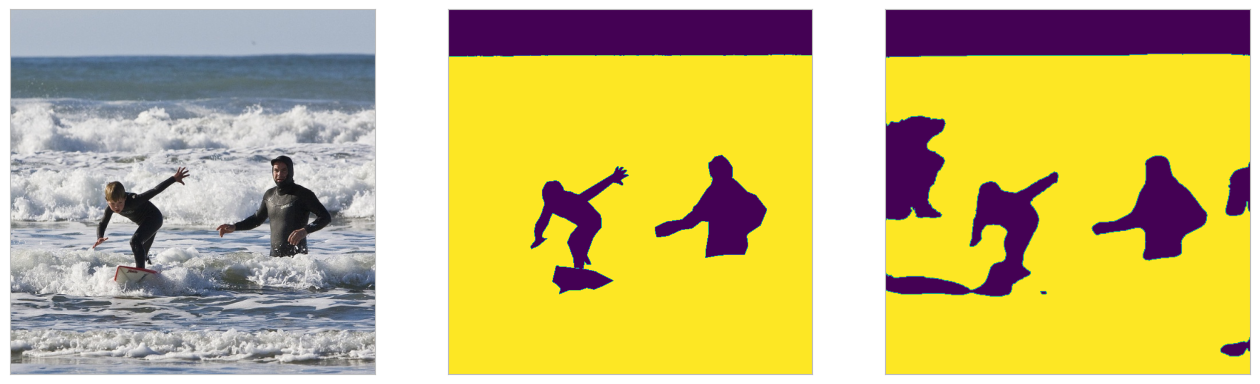

test iou score 0: 0.907882571220398
image shape: (3, 512, 512)


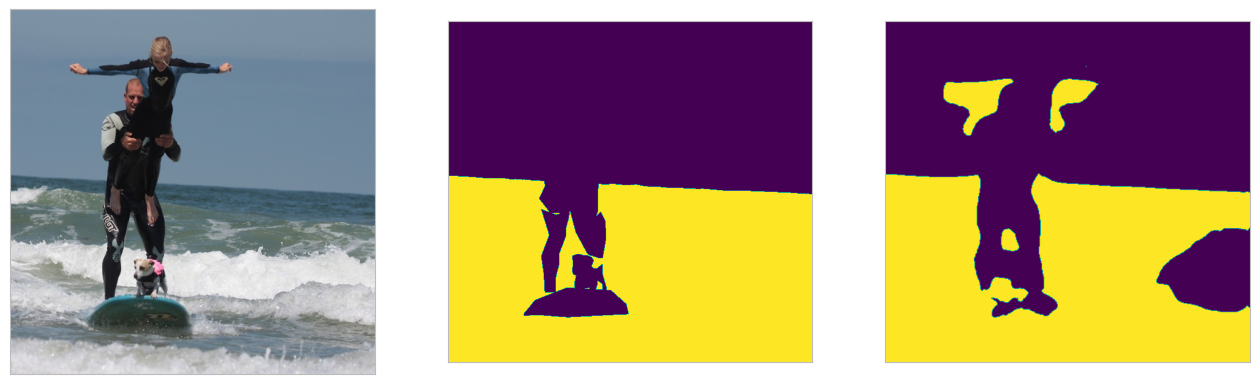

test iou score 1: 0.8052421808242798
image shape: (3, 512, 512)


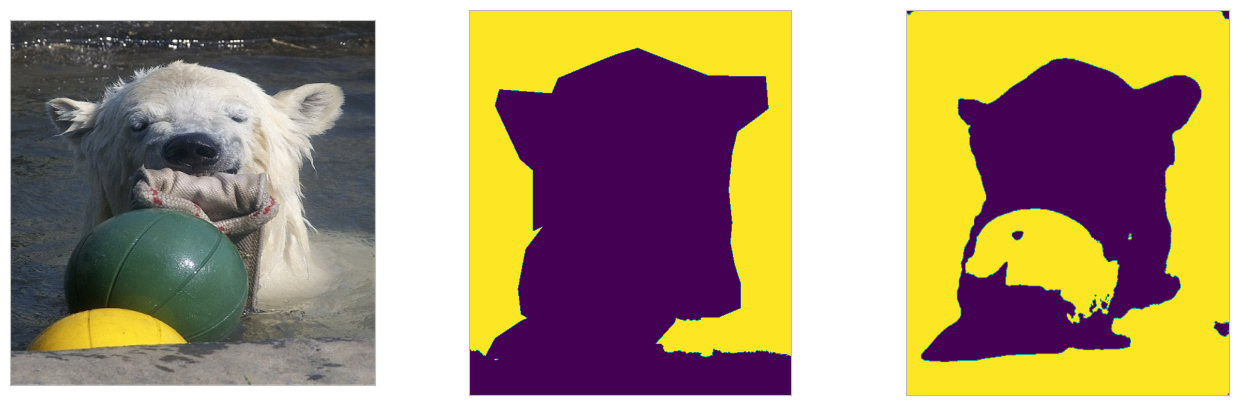

test iou score 2: 0.6213405132293701
image shape: (3, 512, 512)


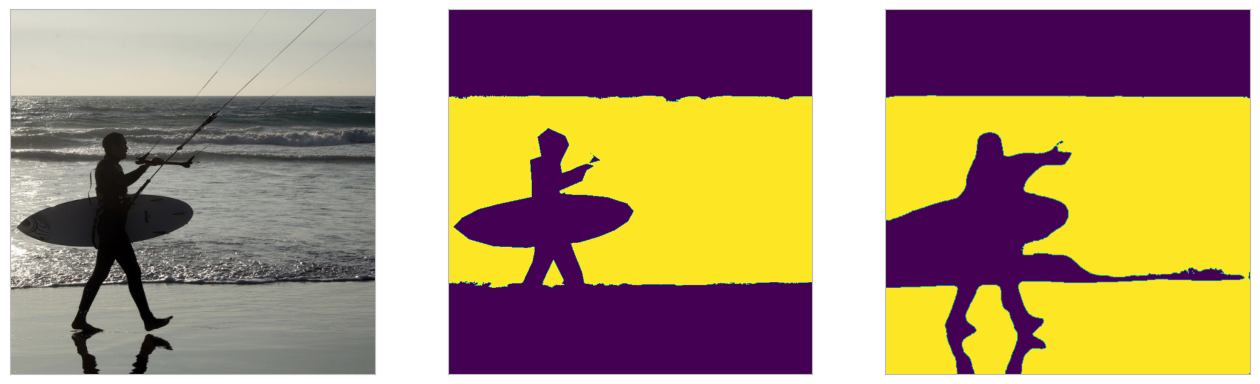

test iou score 3: 0.5611311197280884
image shape: (3, 512, 512)


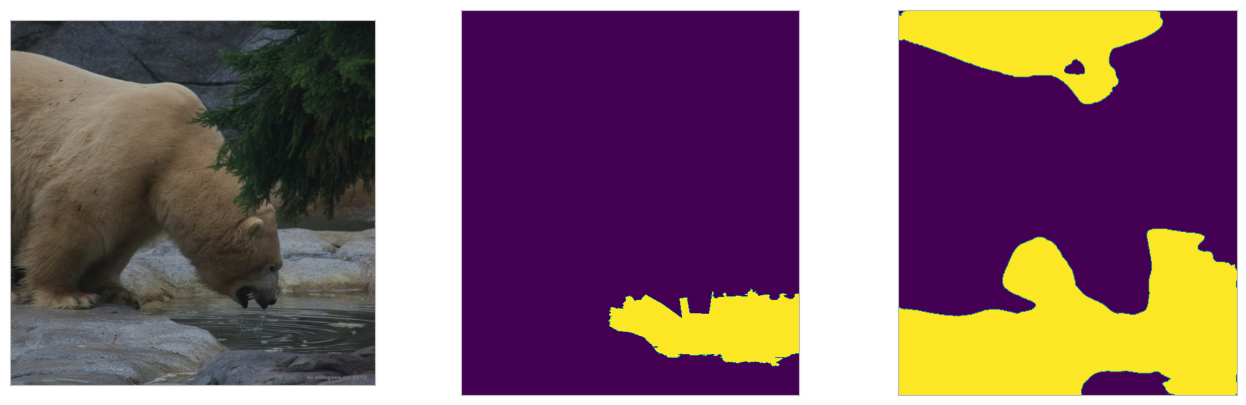

test iou score 4: 0.1894713044166565
avg test iou score: 0.6170135736465454


In [101]:
# testing when you have ground truth and calculate IOU score
def test():

    iou_scores = 0

    # pre_ensemble_best_model.pth
    best_model = torch.load('./ensemble_check_point/ensemble_best_model.pth').to(training_config['device'])
    metrics = smp.utils.metrics.IoU(threshold=0.5)
    ids = os.listdir(x_test_dir)
    images_fps = [os.path.join(x_test_dir, image_id) for image_id in ids]
    gts_fps = [os.path.join(y_test_dir, image_id) for image_id in ids]
    skip = 0
    predict_path = './dataset/predict'
    
    with torch.no_grad():
        best_model.eval()
        
        # calculate average predict mask
        for idx in range(len(test_dataset.ids)):  #len(test_dataset.ids)
    
            n = idx 
            image_vis = test_dataset_vis[n][0].astype('uint8')
            #image, gt_mask = test_dataset[n]
            
            image, gt_mask = test_dataset.__getitem__(n)
            gt_mask = gt_mask.squeeze()
            print(f'image shape: {image.shape}')
            
            #image = image.transpose((2, 0, 1)).astype('float32')
            
            if images_fps[n] == './only_test/.ipynb_checkpoints':
                skip = 1

            ori_img = plt.imread(images_fps[n+skip])
            ori_gt = plt.imread(gts_fps[n])
            ori_gt = ori_gt.squeeze()
        
            x_tensor = torch.from_numpy(image).to(training_config['device']).unsqueeze(0)
            pr_mask = best_model(x_tensor)
            pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
            filename = predict_path + '/ensemble_predict_withIOU_' + str(idx + 1) + '.jpg'
   
            # Saving the image 
            pr_mask = cv2.resize(pr_mask, (ori_img.shape[1], ori_img.shape[0]))
            pr_mask_uint8 = (pr_mask * 255).astype('uint8')
            cv2.imwrite(filename, pr_mask_uint8) 
        
            visualize(
                image = image_vis,
                ground_truth_mask = ori_gt,  #gt_mask
                predicted_mask = pr_mask     
            )
        
            iou_score = metrics.forward(torch.from_numpy(pr_mask), torch.from_numpy(ori_gt))  #gt_mask 
            iou_scores += iou_score

            # (predict, ground_truth)
            print(f'test iou score {idx}: {iou_score}')
    print(f'avg test iou score: {iou_scores / len(test_dataset.ids)}')
    
test()
    

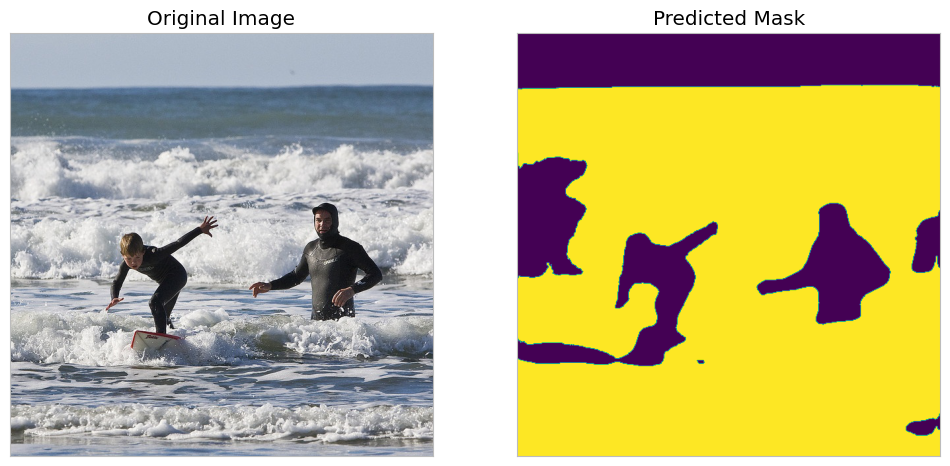

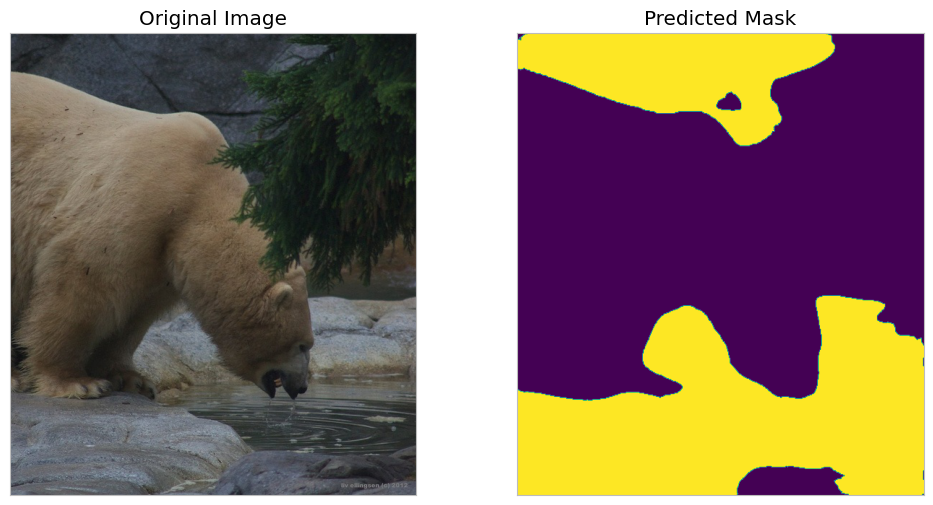

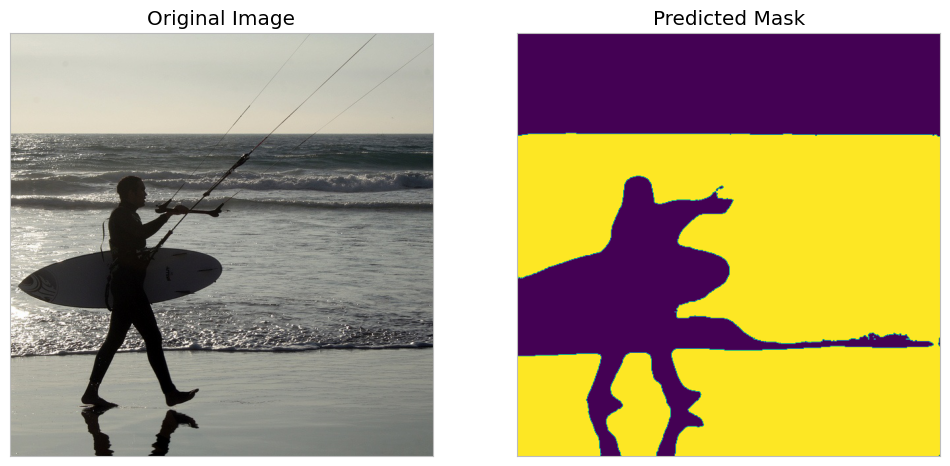

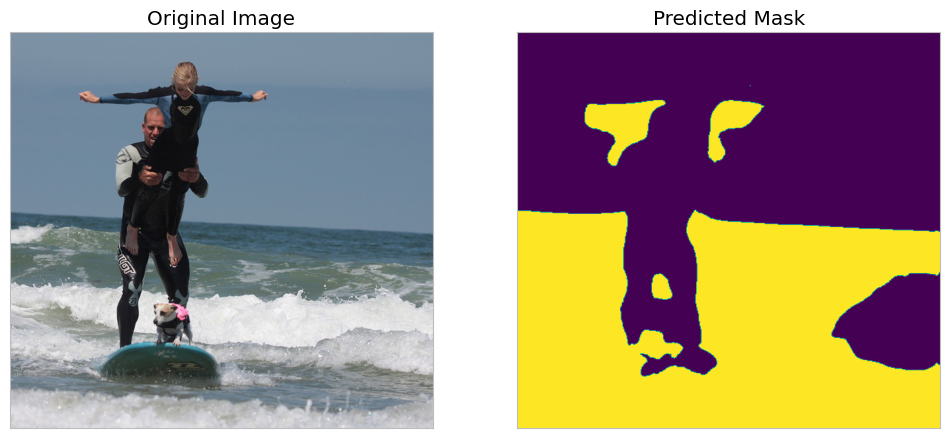

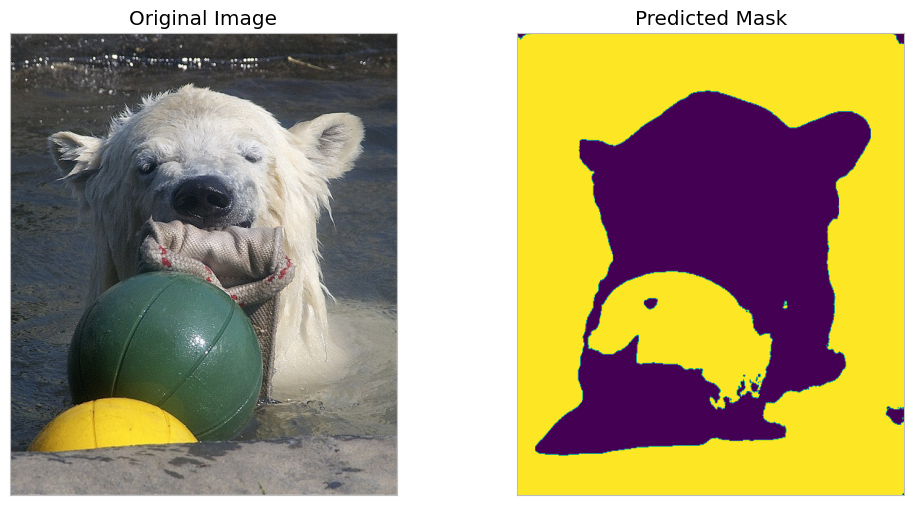

In [106]:
# testing when you don't have ground truth
def test_no_iou():

    #tmp_DIP_final_project/only_test/56.jpg
    test_data_dir = './only_test'
    ids = os.listdir(test_data_dir)
    images_fps = [os.path.join(test_data_dir, image_id) for image_id in ids]
    predict_path = './dataset/predict'


    # testing dataset
    test_dataset = WaterDataset(
        images_dir = test_data_dir,
        #augmentation = get_test_augmentation(),
        #preprocessing = get_preprocessing(preprocessing_fn),
        classes = CLASSES,
    )
     
    # ---------------------------------------------------------------
    
    test_dataset_vis = WaterDataset(
        images_dir = test_data_dir,
        classes = CLASSES,
    )

    # load best model
    # './ensemble_check_point/ensemble_best_model__.pth'
    best_model = torch.load('./ensemble_check_point/ensemble_best_model.pth').to(training_config['device'])
    
    with torch.no_grad():
        best_model.eval()
        # calculate average predict mask
        skip = 0

        for idx in range(len(test_dataset.ids)): # len(test_dataset.ids)

            n = idx
            image_vis = test_dataset_vis[n][0].astype('uint8')
            #image, gt_mask = test_dataset[n]
            image, gt_mask = test_dataset.__getitem__(n)
            #print(f'image.shape: {image.shape}')
            #plt.imshow(image.transpose(1,2,0)) #.transpose(1,2,0)

            
            if images_fps[n] == './only_test/.ipynb_checkpoints':
                skip = 1

            ori_img = plt.imread(images_fps[n + skip])
            index = images_fps[n + skip].split('./only_test/input')
            index = index[1].split('.jpg')[0]

            #print(f'ori_img.shape[0]: {ori_img.shape[0]}, ori_img.shape[1]: {ori_img.shape[1]}')
            #raise
            
            x_tensor = torch.from_numpy(image).to(training_config['device']).unsqueeze(0)
            pr_mask = best_model(x_tensor)
            pr_mask = (pr_mask.squeeze().cpu().numpy().round())

            #filename = predict_path + '/ensemble_predict_' + str(idx + 1) + '.jpg'
            filename = predict_path + '/output' + index + '.jpg'
            
            # Saving the image 
            pr_mask = cv2.resize(pr_mask, (ori_img.shape[1], ori_img.shape[0]))
            pr_mask_uint8 = (pr_mask * 255).astype('uint8')
            cv2.imwrite(filename, pr_mask_uint8) 
  

            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.imshow(ori_img)
            plt.title("Original Image")
            plt.xticks([])
            plt.yticks([])
        
            plt.subplot(1, 2, 2)
            plt.imshow(pr_mask)
            plt.title("Predicted Mask")
            plt.xticks([])
            plt.yticks([])
        
            plt.show()
             


test_no_iou()

In [83]:
# 可以不用跑

import segmentation_models_pytorch as smp
import os
import cv2
import torch

# tmp test iou
pred_path = './cal_iou/predict'
gt_path = './cal_iou/ground_truth'

pred_ids = os.listdir(pred_path)
pred_fps = [os.path.join(pred_path, image_id) for image_id in pred_ids]

gt_ids = os.listdir(gt_path)
gt_fps = [os.path.join(gt_path, image_id) for image_id in gt_ids]


metrics = smp.utils.metrics.IoU(threshold=0.5)

iou_scores = 0
for idx in range(len(pred_ids)):
    print(f'len(pred_ids): {len(pred_ids)}')

    
    pr_mask = cv2.imread(pred_fps[idx], cv2.IMREAD_GRAYSCALE)
    print(f'pr_mask shape: {pr_mask.shape}')

    img_idx = pred_fps[idx].split('./cal_iou/predict/')[1]
    gt_img_path = gt_path + '/' + img_idx

    gt_mask = cv2.imread(gt_img_path, cv2.IMREAD_GRAYSCALE)


    for i in range(pr_mask.shape[0]):
        for j in range(pr_mask.shape[1]):
            if pr_mask[i][j] == 255:
                pr_mask[i][j] = 1
            else:
                pr_mask[i][j] = 0

            if gt_mask[i][j] == 255:
                gt_mask[i][j] = 1
            else:
                gt_mask[i][j] = 0


    iou_score = metrics.forward(torch.from_numpy(pr_mask), torch.from_numpy(gt_mask))
    iou_scores += iou_score
    print(f'test iou score {idx}: {iou_score}')

print(f'avg test iou score: {iou_scores / len(pred_ids)}')


pred_fps: ['./cal_iou/predict/11.jpg', './cal_iou/predict/56.jpg']
gt_fps: ['./cal_iou/ground_truth/56.jpg', './cal_iou/ground_truth/11.jpg']
len(pred_ids): 2
pr_mask shape: (1650, 2200)
test iou score 0: 1.0
len(pred_ids): 2
pr_mask shape: (640, 640)
test iou score 1: 1.0
avg test iou score: 1.0


In [107]:
## 助教的 IOU 算法

import cv2
import numpy as np

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# 假設你有10對mask的檔案名稱，這裡只是一個例子，請替換成你的實際檔案名稱
gt_test_dir = './dataset/test/mask/'
pred_test_dir = './dataset/predict/'

mask_filenames_1 = ["output1.jpg", "output2.jpg", "output3.jpg", "output4.jpg", "output5.jpg"]
mask_filenames_2 = ["56.jpg",  "57.jpg", "58.jpg", "59.jpg", "60.jpg"]

total_iou = 0

for i in range(5):  # 修改為實際的mask數量
    # 讀取兩個mask
    mask1 = cv2.imread(pred_test_dir + mask_filenames_1[i], cv2.IMREAD_GRAYSCALE) 
    mask2 = cv2.imread(gt_test_dir + mask_filenames_2[i], cv2.IMREAD_GRAYSCALE)

    # 將mask二值化 (假設是二值化的黑白圖片)
    _, mask1 = cv2.threshold(mask1, 128, 255, cv2.THRESH_BINARY)
    _, mask2 = cv2.threshold(mask2, 128, 255, cv2.THRESH_BINARY)

    # 計算IOU並加總
    iou = calculate_iou(mask1, mask2)
    total_iou += iou
    print(f"IoU for pair {i + 1}: {iou}")

# 計算平均IoU
average_iou = total_iou / len(mask_filenames_1)
print(f"Average IoU: {average_iou}")



IoU for pair 1: 0.9079710101308035
IoU for pair 2: 0.5611685349638472
IoU for pair 3: 0.8052616215427278
IoU for pair 4: 0.6212917435888062
IoU for pair 5: 0.18944189230193845
Average IoU: 0.6170269605056247
